In [1]:
# load libraries
%matplotlib notebook
import matplotlib
import matplotlib.pyplot as plt
from IPython.display import clear_output
import random
from math import sqrt

In [2]:
# compute dot
def dot(dim):
    dist = 0
    dotx = [None] * dim
    for coord in range(dim):
        dotx[coord] = random.uniform(-0.5, 0.5)
        dist += dotx[coord] ** 2
    return dotx, sqrt(dist)

In [3]:
# set variables
d_max = 20
points = 10 ** 5
dims = []
ratios = []

<IPython.core.display.Javascript object>


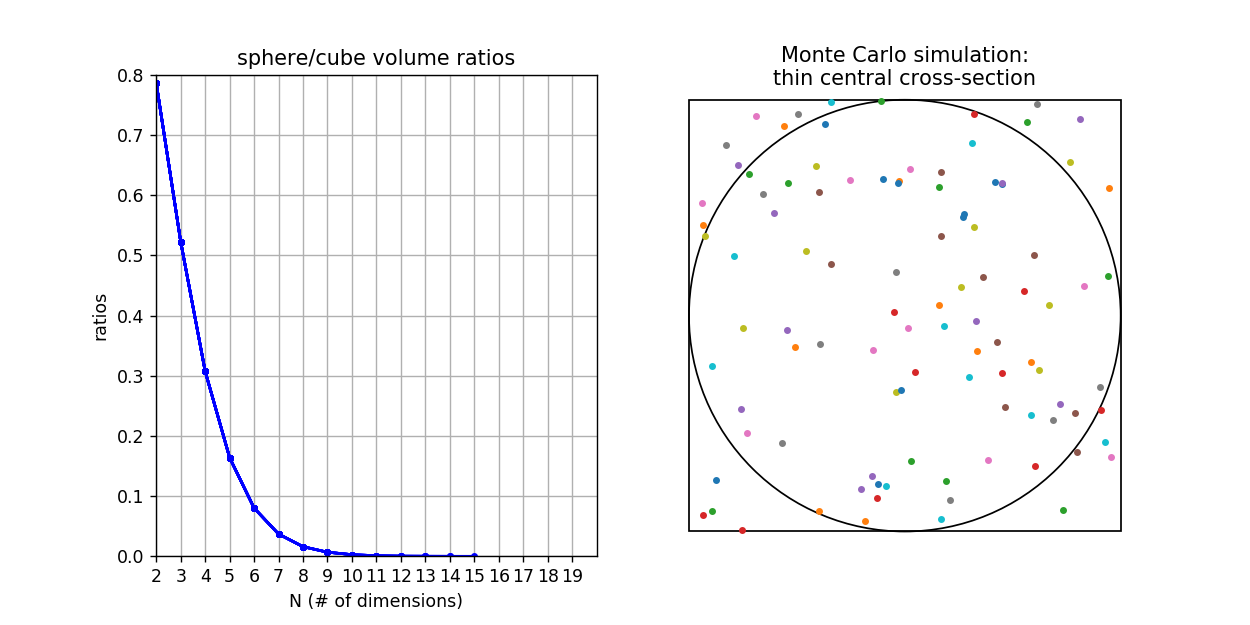

In [4]:
# initialize plot
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(10, 5))
ax1.set_xlabel('N (# of dimensions)')
ax1.set_ylabel('ratios')
ax1.set_title('sphere/cube volume ratios')
ax1.set_xlim(2, d_max)
ax1.set_ylim(0, 0.8)
ax1.set_xticks(range(2, d_max))
ax1.grid()
square1 = plt.Rectangle((-0.5, -0.5), 1, 1, linewidth = 1, edgecolor='black', facecolor='white')
circle1 = plt.Circle((0, 0), 0.5, color='black', fill=False)

In [5]:
# main loop
for d in range(2, d_max):
    p_int = 0
    ax2.clear()
    ax2.set_aspect(1.0)
    ax2.set_axis_off()
    ax2.set_xlim(-0.51, 0.51)
    ax2.set_ylim(-0.51, 0.51)
    ax2.set_title('Monte Carlo simulation:\nthin central cross-section')
    ax2.add_artist(square1)
    ax2.add_artist(circle1)
    for p in range(points):
        dotx, dist = dot(d)
        if dist <= 0.5:
            p_int += 1
        if p % (points / 100) == 0:
            ax2.plot(dotx[0], dotx[1], '.')
            fig.canvas.draw()
    ratio = p_int / points
    dims.append(d)
    ratios.append(ratio)
    ax1.plot(dims, ratios, '.b-')
    fig.canvas.draw()
    if p_int == 0:
        break